# Temporal analysis on a real dataset 

In the past sections we have performed inference on the SIR model artificial dataset, in particular we have tried to infer the principal parameters governing the spreading of the pandemic. 

In this section we are introducing a real dataset, given by the John Hopkins University and updated until **3/10/2023** available at https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

In the dataset, data taken from 201 countries are listed, showing also the latitude and longitude coordinates. As described in the paper, we are going to select only data referred to the spreading disease of the pandemic in Germany, starting from **22/01/2020** until **3/10/2023**. The code and method adopted is the same as described previously.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt 
import os
import numpy as np
from scipy.integrate import odeint
import scipy.stats as stats
import pymc as pm
import pytensor 
import pytensor.tensor as pt
import pandas as pd 
import arviz as az 
import multiprocessing
from datetime import datetime, timedelta 
from SIR_functions import metropolis_hastings, metropolis_hastings_multi_chain
import requests

In [3]:
## Download the latest dataset informations  

url_conf = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_rec = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

filename_conf = 'confirmed_cases.csv'
filename_death = 'death_cases.csv'
filename_rec = 'rec_cases.csv'

response_conf, response_death, response_rec = requests.get(url_conf), requests.get(url_death), requests.get(url_rec)
with open(filename_conf, 'wb') as file:
    file.write(response_conf.content)
with open(filename_death, 'wb') as file:
    file.write(response_death.content)
with open(filename_rec, 'wb') as file:
    file.write(response_rec.content)

print('Csv files downloaded successfully.')



Csv files downloaded successfully.


In [36]:
confirmed_cases = pd.read_csv(filename_conf)
deaths_confirmed = pd.read_csv(filename_death)
recovered_confirmed = pd.read_csv(filename_rec)

# Showing the dataset and dropping not informative columns 
confirmed_cases = confirmed_cases.drop(columns = ["Province/State", "Lat", "Long"], axis = 1)
deaths_confirmed = deaths_confirmed.drop(columns = ["Province/State", "Lat", "Long"], axis = 1)
recovered_confirmed = recovered_confirmed.drop(columns = ["Province/State", "Lat", "Long"], axis = 1)
confirmed_cases

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,Albania,0,0,0,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,Algeria,0,0,0,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,Andorra,0,0,0,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,Angola,0,0,0,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,West Bank and Gaza,0,0,0,0,0,0,0,0,0,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,703228
285,Winter Olympics 2022,0,0,0,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
286,Yemen,0,0,0,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945
287,Zambia,0,0,0,0,0,0,0,0,0,...,343012,343012,343079,343079,343079,343135,343135,343135,343135,343135


In [ ]:
# Cella da eliminare nel notebook finale

'''
confirmed_cases = pd.read_csv(r'data/confirmed_global_fallback_2020-04-28.csv')
deaths_confirmed = pd.read_csv(r'data/deaths_global_fallback_2020-04-28.csv')
recovered_confirmed = pd.read_csv(r'data/recovered_global_fallback_2020-04-28.csv')
'''

"\nconfirmed_cases = pd.read_csv(r'data/confirmed_global_fallback_2020-04-28.csv')\ndeaths_confirmed = pd.read_csv(r'data/deaths_global_fallback_2020-04-28.csv')\nrecovered_confirmed = pd.read_csv(r'data/recovered_global_fallback_2020-04-28.csv')\n"

In [35]:
# Counting the number of countries listed in the dataset 

countries = confirmed_cases["Country/Region"].unique()
print(f'Number of countries considered: {len(countries)}')

Number of countries considered: 201


In [15]:
confirmed_cases[confirmed_cases['Country/Region'] == 'Germany']
confirmed_cases['4/21/20']

0      1026
1       609
2      2811
3       717
4        24
       ... 
284     329
285       0
286       1
287      70
288      28
Name: 4/21/20, Length: 289, dtype: int64

In [37]:
n = len(confirmed_cases[confirmed_cases['Country/Region'] == 'Germany'])
g_I_new = confirmed_cases[confirmed_cases['Country/Region'] == 'Germany'].dropna(axis = 1)
g_R = recovered_confirmed[recovered_confirmed['Country/Region'] == 'Germany'].dropna(axis = 1)
g_D = deaths_confirmed[deaths_confirmed['Country/Region'] == 'Germany'].dropna(axis = 1)

# Checking for NaN values 
print(f'Number of values dropped: {len(g_I_new) - n}')

Number of values dropped: 0


In [38]:
num_col_dropped = confirmed_cases[confirmed_cases['Country/Region'] == 'Germany'].shape[1] - g_I_new.shape[1]
print(confirmed_cases[confirmed_cases['Country/Region'] == 'Germany'].shape[1])
print(g_I_new.shape[1])
print(f'Number of columns dropped: {num_col_dropped}')

1144
1144
Number of columns dropped: 0


In [19]:
# Si può eliminare?

'''
numeric_cols = g_I_new.columns[3:]

# Trova la prima colonna in cui il numero di casi è maggiore o uguale a 50
col_index_start = np.argmax(g_I_new.loc[:, numeric_cols].values.flatten() >= 50)

# Ora seleziona tutte le colonne dalla prima colonna >=80 in poi
g_I_new_from_100 = g_I_new.iloc[:, col_index_start+1 : ]  # +1 se hai la prima colonna non numerica
g_R_from_100=g_R.iloc[:, col_index_start+1 : ]
g_D_from_100=g_D.iloc[:, col_index_start+1 : ]

print(g_R_from_100.shape)
print(g_I_new_from_100.shape)
print("Primo giorno con almeno 50 casi:", g_I_new_from_100.columns[0])
g_I_new_from_100
'''

'\nnumeric_cols = g_I_new.columns[3:]\n\n# Trova la prima colonna in cui il numero di casi è maggiore o uguale a 50\ncol_index_start = np.argmax(g_I_new.loc[:, numeric_cols].values.flatten() >= 50)\n\n# Ora seleziona tutte le colonne dalla prima colonna >=80 in poi\ng_I_new_from_100 = g_I_new.iloc[:, col_index_start+1 : ]  # +1 se hai la prima colonna non numerica\ng_R_from_100=g_R.iloc[:, col_index_start+1 : ]\ng_D_from_100=g_D.iloc[:, col_index_start+1 : ]\n\nprint(g_R_from_100.shape)\nprint(g_I_new_from_100.shape)\nprint("Primo giorno con almeno 50 casi:", g_I_new_from_100.columns[0])\ng_I_new_from_100\n'

In [39]:
num_col_dropped = confirmed_cases[confirmed_cases['Country/Region'] == 'Germany'].shape[1] - g_I_new.shape[1]
print(confirmed_cases[confirmed_cases['Country/Region'] == 'Germany'].shape[1])
print(g_I_new.shape[1])
print(f'Number of columns dropped: {num_col_dropped}')

1144
1144
Number of columns dropped: 0


In [42]:
print(f'Date begin simulation: {g_I_new.iloc[:, 1]}')
print(f'Date end simulation: {g_I_new.iloc[:, -1]}')

Date begin simulation: 135    0
Name: 1/22/20, dtype: int64
Date end simulation: 135    38249060
Name: 3/9/23, dtype: int64


In [49]:
col_index_start = 1
col_index_stop = len(g_I_new.columns)

In [50]:
I_new = np.array(g_I_new.iloc[0, col_index_start:col_index_stop], dtype = np.float64)
R = np.array(g_R.iloc[0, col_index_start:col_index_stop], dtype = np.float64) 
D = np.array(g_D.iloc[0, col_index_start:col_index_stop], dtype = np.float64) 

Number of days indexed: 1143


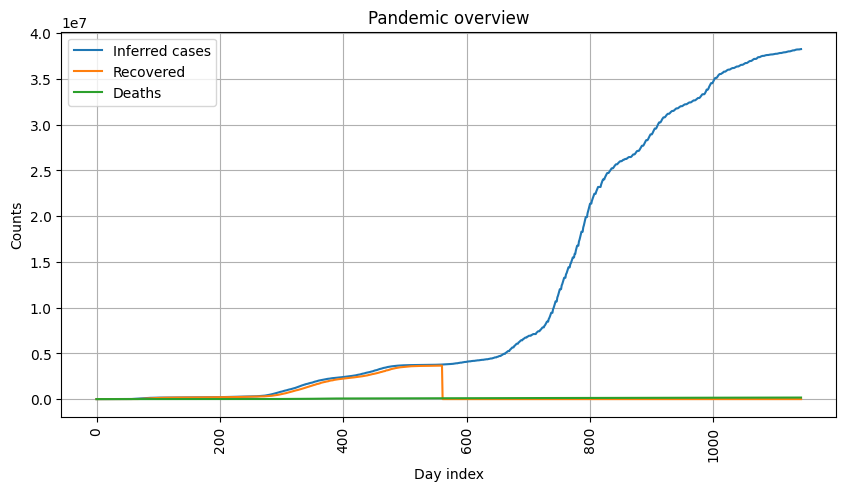

In [47]:
index = [i for i in range(len(I_new + 1))] 
print(f'Number of days indexed: {len(index)}')
labels = g_I_new.columns[col_index_start:col_index_stop]

plt.figure(figsize = (10, 5))
plt.plot(index, I_new, label = 'Inferred cases')
plt.plot(index, R, label = 'Recovered')
plt.plot(index, D, label = 'Deaths')
plt.xlabel('Day index')
plt.ylabel('Counts')
plt.xticks(rotation=90)

plt.legend()
plt.grid()
plt.title('Pandemic overview')
plt.show()

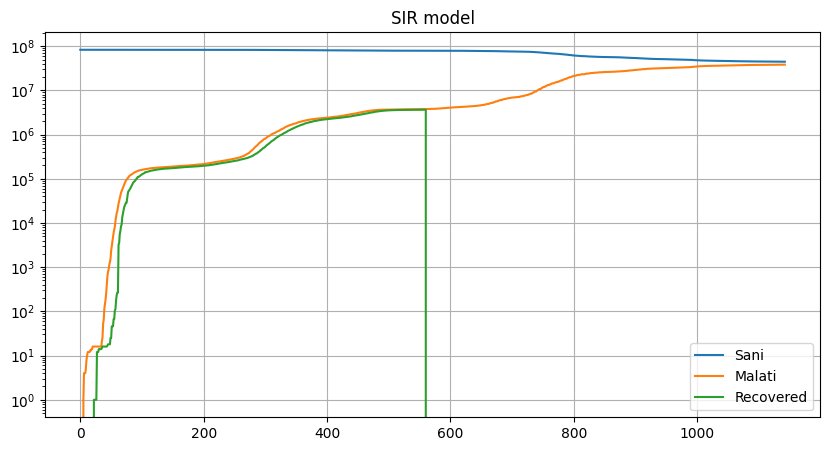

In [48]:
# SIR model plot 

N = 83e6
S = np.zeros(I_new.shape)
S = N - I_new - D # sottraggo infetti e morti ai sani 

fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(index, S, label = 'Sani')
ax.plot(index, I_new, label = 'Malati')
ax.plot(index, R, label = 'Recovered')
ax.set_yscale('log')
plt.legend()
plt.grid()
plt.title('SIR model')
plt.show()

In [51]:
print(f'Number of days considered: {len(labels)}')

Number of days considered: 1143


## Inferring real data covid spreading with MCMC sampling 

First, we try to infer the parameters using the MCMC algorithm used before, taking the structure from the 3 switches and delay case.

In [53]:
from SIR_functions import sir_discrete_delay_multi_sw

# ---- PARAMETERS ----
N = 83e6  # Population size
t_max = len(labels)  # Total days of simulation

# Priors
sigma_beta, mu_beta = 0.5, np.log(0.4)
sigma_beta_2, mu_beta_2 = 0.5, np.log(0.2)
sigma_beta_3, mu_beta_3 = 0.5, np.log(1/8)
sigma_beta_4, mu_beta_4 = 0.5, np.log(1/16)
sigma_gamma, mu_gamma = 0.2, np.log(1/8)
sigma_delay, mu_delay = 0.2, np.log(8)
sigma_I0 = 100
sigma_scale = 10
sigma_time1, mu_time1 = 3, 10
sigma_time2, mu_time2 = 1, 20
sigma_time3, mu_time3 = 1, 30
sigma_dt, mu_dt = 0.3, np.log(3)

# ---- PRIOR FUNCTION ----
def log_prior(beta1, beta2, beta3, beta4, gamma, delay, I0, scale, t_switch1, t_switch2, t_switch3, dt_switch):
    logp = (    
        stats.lognorm.logpdf(beta1, s=sigma_beta, scale=np.exp(mu_beta)) +
        stats.lognorm.logpdf(beta2, s=sigma_beta_2, scale=np.exp(mu_beta_2)) +
        stats.lognorm.logpdf(beta3, s=sigma_beta_3, scale=np.exp(mu_beta_3)) +
        stats.lognorm.logpdf(beta4, s=sigma_beta_4, scale=np.exp(mu_beta_4)) +
        stats.lognorm.logpdf(gamma, s=sigma_gamma, scale=np.exp(mu_gamma)) +
        stats.lognorm.logpdf(delay, s=0.2, scale=np.exp(np.log(8))) +
        stats.halfcauchy.logpdf(I0, scale=sigma_I0) +
        stats.halfcauchy.logpdf(scale, scale=sigma_scale) +
        stats.norm.logpdf(t_switch1, loc = mu_time1, scale = sigma_time1) +
        stats.norm.logpdf(t_switch2, loc = mu_time2, scale = sigma_time2) +
        stats.norm.logpdf(t_switch3, loc = mu_time3, scale = sigma_time3) + 
        stats.lognorm.logpdf(dt_switch, s = sigma_dt, scale = np.exp(mu_dt))
    )
    return logp

# ---- LOG-LIKELIHOOD ----
def log_likelihood(params, data):
    beta1, beta2, beta3, beta4, gamma, delay, I0, scale, t_switch1, t_switch2, t_switch3, dt_switch = params
    I_pred, C_pred = sir_discrete_delay_multi_sw(beta1, beta2, beta3, beta4, gamma, delay, I0, scale, t_switch1, t_switch2, t_switch3, dt_switch, t_max, N)  # Solve SIR model with delay


    # Likelihood: Assume reported cases C_t follows Normal(C_pred, scale)
    return np.sum(stats.norm.logpdf(data, loc=C_pred, scale=scale))

# ---- LOG-POSTERIOR ----
def log_posterior(params, data):
    beta1, beta2, beta3, beta4, gamma, delay, I0, scale, t_switch1, t_switch2, t_switch3, dt_switch = params
    prior = log_prior(beta1, beta2, beta3, beta4, gamma, delay, I0, scale, t_switch1, t_switch2, t_switch3, dt_switch) 
    if np.isinf(prior) or np.isnan(prior):
        return -np.inf  # Reject invalid samples
    return prior + log_likelihood(params, data)



n_chains = 20  # Numero di catene
true_params = np.array([0.4, 0.2, 1/8, 1/16, 1/8, 8, 100, 2, 10, 20, 30, 3])

params = np.array([0.5, 0.3, 0.17, 0.12, 0.15, 6, 80, 1.5, 60, 65, 70, 2.5])


# Nuovi intervalli di generazione basati sulle migliori stime
initial_params_list = [
    params + np.random.normal(0, [0.02, 0.02, 0.01, 0.01, 0.01, 2, 2, 0.2, 0.5, 0.5, 0.5, 0.05], 12)
    for _ in range(n_chains)
]

step_sizes_list = [
    np.array([0.01, 0.02, 0.02, 0.02, 0.05, 1, 20, 0.05, 5, 5, 5, 0.1]) + np.random.uniform(-0.005, 0.005, 12)
    for _ in range(n_chains)
]

samples_all_chains = metropolis_hastings_multi_chain(log_posterior, initial_params_list, step_sizes_list, I_new, n_iter=20000, n_chains=n_chains)

param_names = param_names = ["beta1", "beta2", "beta3", "beta4", "gamma", "delay", "I0", "scale", "t_switch1", "t_switch2", "t_switch3", "dt_switch"]

fig, axes = plt.subplots(len(param_names), 1, figsize=(10, 2 * len(param_names)), sharex=True)

for i, ax in enumerate(axes):
    for chain in samples_all_chains:
        ax.plot(chain[:, i], alpha=0.5)
    ax.set_ylabel(param_names[i])
    ax.grid()

axes[-1].set_xlabel("Iteration")
plt.suptitle("Convergenza delle catene MCMC")
plt.tight_layout()
plt.show()

Running chain 1/20...


/Users/ada.diorio/Desktop/IT/SIR_functions.py:283: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(logp_new - logp_old)
/Users/ada.diorio/Desktop/IT/SIR_functions.py:180: RuntimeWarning: overflow encountered in exp
  transition1 = 1 / (1 + np.exp(-(t - t_switch1) / delta_t))
/Users/ada.diorio/Desktop/IT/SIR_functions.py:181: RuntimeWarning: overflow encountered in exp
  transition2 = 1 / (1 + np.exp(-(t - t_switch2) / delta_t))
/Users/ada.diorio/Desktop/IT/SIR_functions.py:190: RuntimeWarning: overflow encountered in scalar multiply
  I_new[t] = beta * S[t-1] * I[t-1] / N  # New infections
/Users/ada.diorio/Desktop/IT/SIR_functions.py:195: RuntimeWarning: invalid value encountered in scalar subtract
  I[t] = I[t-1] + I_new[t] - R_new
/Users/ada.diorio/miniconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:365: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC


Running chain 2/20...


/Users/ada.diorio/Desktop/IT/SIR_functions.py:182: RuntimeWarning: overflow encountered in exp
  transition3 = 1 / (1 + np.exp(-(t - t_switch3) / delta_t))


KeyboardInterrupt: 

In [ ]:
burn_in = 1000
mean_estimates = np.mean(samples_all_chains[:, -burn_in:, :], axis=(0, 1))
std_estimates = np.std(samples_all_chains[:, -burn_in:, :], axis=(0, 1))

beta1_sampled, beta2_sampled, beta3_sampled, beta4_sampled, gamma_sampled, delay_sampled, I0_sampled, scale_sampled, t_switch1_sampled, t_switch2_sampled, t_switch3_sampled, dt_switch_sampled = mean_estimates

print("True Params:")
print(f"  Beta1: {true_params[0]:.4f}, Beta2: {true_params[1]:.4f}, Beta3: {true_params[2]:.4f}, Beta4: {true_params[3]:.4f}, Gamma: {true_params[4]:.4f}, delay: {true_params[5]:.4f}, I0: {true_params[6]}, Scale: {true_params[7]}, t_switch1: {true_params[8]},  t_switch2: {true_params[9]},  t_switch3: {true_params[10]}, dt_switch: {true_params[11]}")

print("Inferred Params:")
for name, mean, std in zip(param_names, mean_estimates, std_estimates):
    print(f"  {name}: {mean:.4f} ± {std:.4f}")
    
# ---- GENERIAMO LE DUE SIMULAZIONI ----
I_sampled_model, C_sampled_model = sir_discrete_delay_multi_sw(*mean_estimates, t_max, N)

fig, ax = plt.figure(figsize=(10, 6))

# Plot Infected Cases
plt.plot(I_new, label="True Params model", color="blue")
plt.plot(I_sampled_model, label="Inferred Params model", color="red", linestyle="dashed")
plt.set_ylabel("Prevalence")
plt.legend()
plt.grid()


plt.title("Comparison between true params model and inferred params model")
plt.tight_layout()
plt.show()

In [ ]:
# Simulating the SIR model with inferred parameters from the true dataset distribution

# Basic sir model, just for the plot 
def sir_model(y, t, beta1, beta2, beta3, beta4, gamma, delay, t_switch1, t_switch2, t_switch3, dt_switch, N, I_sampled_model):
    S, I, R = y
        # Smooth transitions between beta values   
    transition1 = 1 / (1 + np.exp(-(t - t_switch1) / dt_switch))
    transition2 = 1 / (1 + np.exp(-(t - t_switch2) / dt_switch))
    transition3 = 1 / (1 + np.exp(-(t - t_switch3) / dt_switch))

        # Weighted combination of beta values
    beta = (beta1 * (1 - transition1) + 
            beta2 * (transition1 * (1 - transition2)) + 
            beta3 * (transition2 * (1 - transition3)) + 
            beta4 * transition3)
    
    if int(t - delay) >= 0:  # Assicurati che t - delay sia un indice valido
        I_past = I_sampled_model[int(t - delay)]  # Infezioni avvenute 'delay' giorni fa
    else:
        I_past = 0  # Se t - delay è negativo, considera che non ci sono infezioni passate
    
    # Calcolare le derivate
    dSdt = -beta * S * I_past / N  # Nuove infezioni dipendono dalle infezioni ritardate
    dIdt = beta * S * I_past / N - gamma * I  # Infezioni e recupero
    dRdt = gamma * I  # Recuperi
    
    return [dSdt, dIdt, dRdt]  # Non è più necessario restituire I_past_array

# ---- SOLVE SIR MODEL USING ESTIMATED PARAMETERS ----
S0_est = N - I0_sampled
y0_est = [S0_est, I0_sampled, 0]  # Initial conditions

sol_est = odeint(sir_model, y0_est, t, args=(beta1_sampled, beta2_sampled, beta3_sampled, beta4_sampled, 
                                             gamma_sampled, delay_sampled, t_switch1_sampled, 
                                             t_switch2_sampled, t_switch3_sampled, dt_switch_sampled, N, I_sampled_model))

S_est, I_est, R_est = sol_est[:, 0], sol_est[:, 1], sol_est[:, 2]

# ---- PLOT THE EVOLUTION OF S, I, R ----

plt.figure(figsize=(10, 5))

# Traccia le curve per S, I, R
plt.plot(t, S_est, label="Susceptible (S)", color="blue", linewidth=2)
plt.plot(t, I_est, label="Infected (I)", color="red", linewidth=2)
plt.plot(t, R_est, label="Recovered (R)", color="green", linewidth=2)

# Linea verticale per t_switch
plt.axvline(x=t_switch1_sampled, color="black", linestyle="dashed", linewidth=1.5, label=f"t_switch = {t_switch1_sampled:.1f}")
plt.axvline(x=t_switch2_sampled, color="black", linestyle="dashed", linewidth=1.5, label=f"t_switch = {t_switch2_sampled:.1f}")
plt.axvline(x=t_switch3_sampled, color="black", linestyle="dashed", linewidth=1.5, label=f"t_switch = {t_switch3_sampled:.1f}")



# Miglioramenti estetici
plt.xlabel("Time", fontsize=12)
plt.ylabel("Population", fontsize=12)
plt.title("Evolution of S, I, R over Time", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

# Mostra il grafico
plt.show()

## Inferring real data with PYMC

We are now going to apply the PYMC algorithm to our dataset.

Initializing NUTS using jitter+adapt_diag...
c:\ProgramData\anaconda3\lib\site-packages\pytensor\link\c\cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta1, beta2, beta3, beta4, transient_begin_0, transient_begin_1, transient_begin_2, transient_len_0, transient_len_1, transient_len_2, gamma, I0, delay, scale_delay, scale, weekend_factor]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 8556 seconds.
There were 757 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


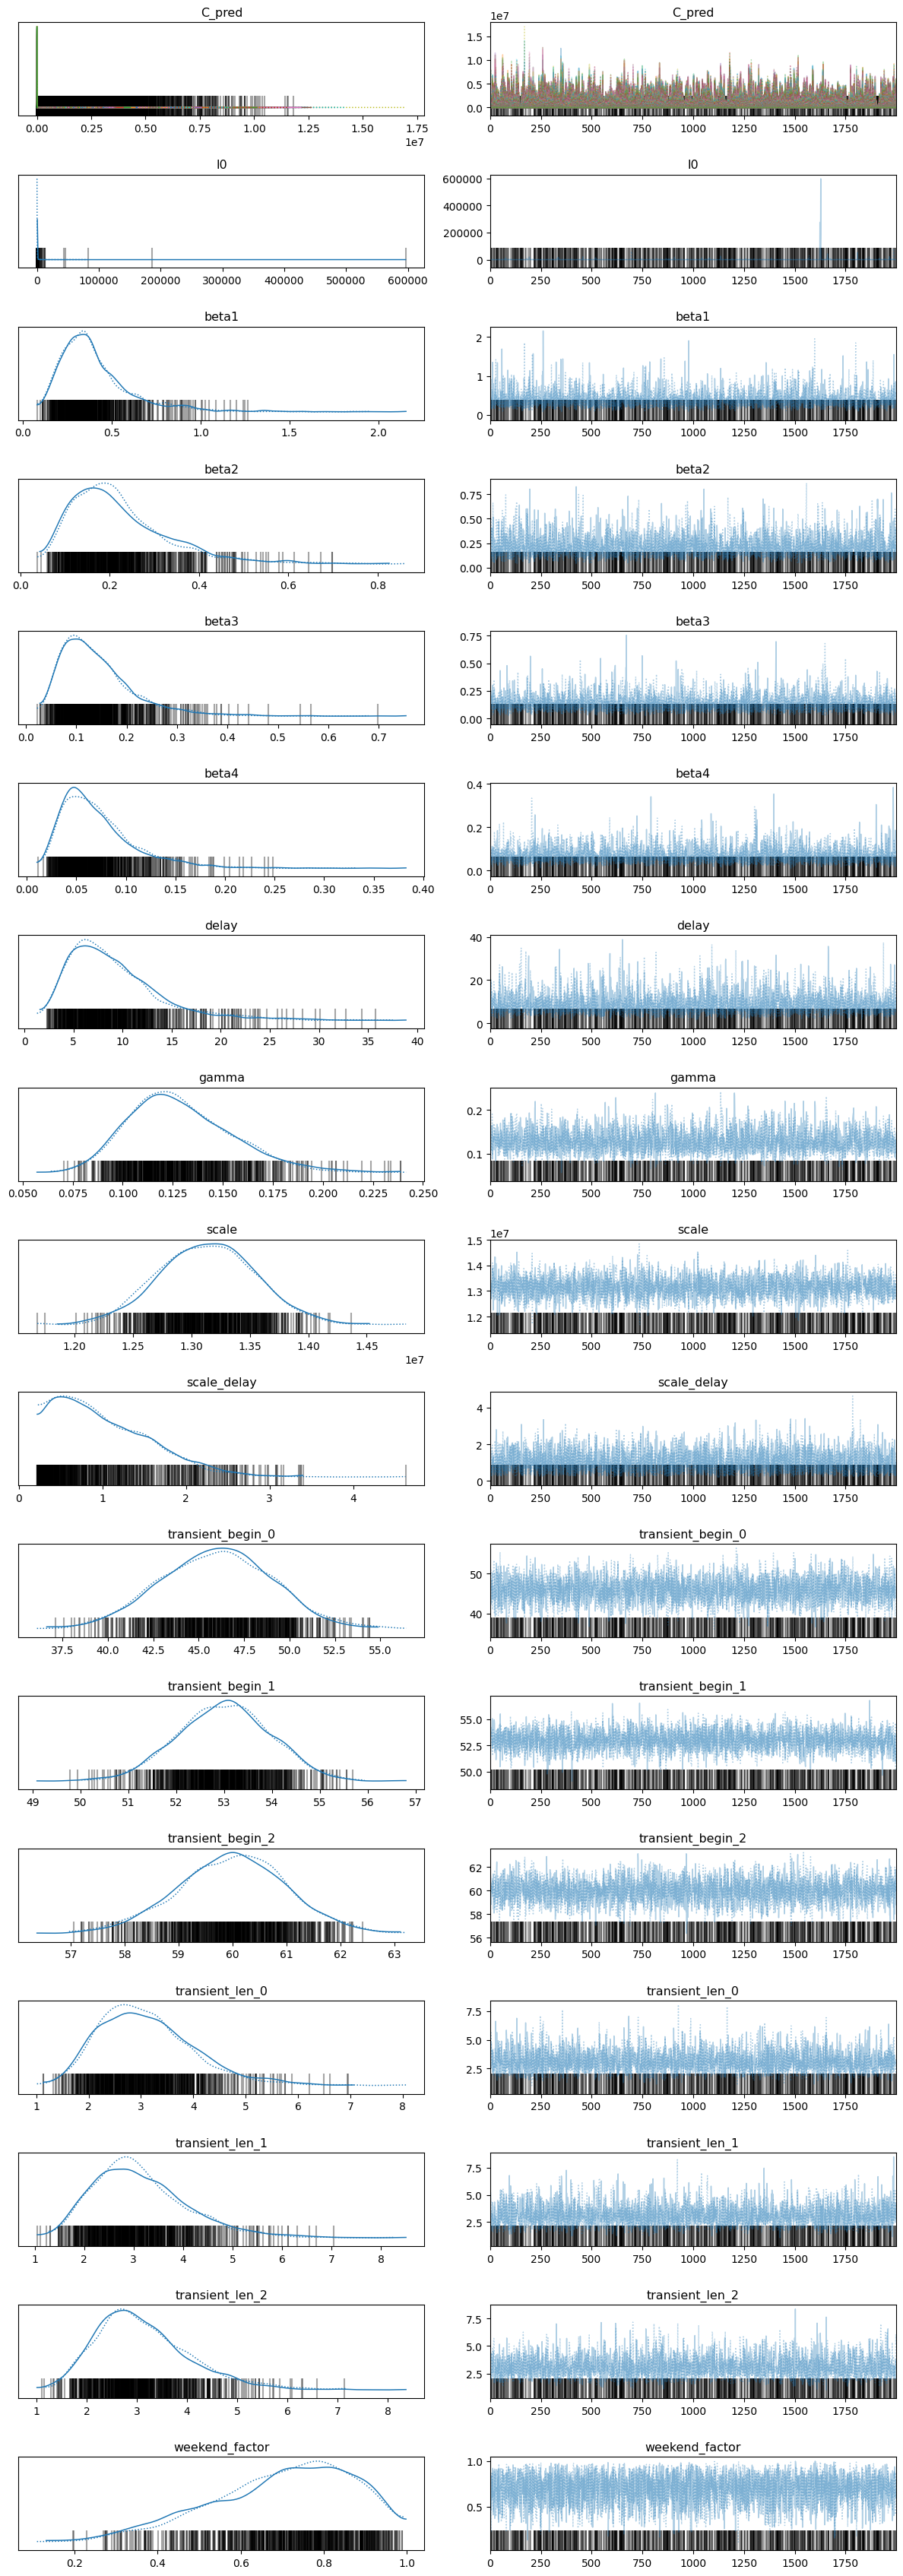

In [ ]:
from scipy.integrate import odeint
import scipy.stats as stats
import pymc as pm
import pytensor
import pytensor.tensor as pt
import numpy as np
from datetime import datetime, timedelta 
import arviz as az
import matplotlib.pyplot as plt
from SIR_functions import _SIR_model, smooth_step_function, delay_cases_lognormal, make_delay_matrix

def SIR_with_change_points(
    new_cases_obs,
    change_points_list,
    date_begin_simulation,
    num_days_sim,
    diff_data_sim,
    N,
    weekends_modulated=True,
    weekend_modulation_type='step'):

    with pm.Model() as model:
        beta1 = pm.Lognormal("beta1", mu=np.log(0.4), sigma=0.5)
        beta2 = pm.Lognormal("beta2", mu = np.log(0.2), sigma = 0.5)
        beta3 = pm.Lognormal("beta3", mu = np.log(1/8), sigma = 0.5)
        beta4 = pm.Lognormal("beta4", mu = np.log(1/16), sigma = 0.5)

        lambda_list = [beta1, beta2, beta3, beta4]
 
        # list of start dates of the transient periods of the change points
        tr_begin_list = []
        dt_before = date_begin_simulation
        for i, cp in enumerate(change_points_list):
            dt_begin_transient = cp["pr_mean_date_begin_transient"]
            if dt_before is not None and dt_before > dt_begin_transient:
                raise RuntimeError("Dates of change points are not temporally ordered")
            prior_mean = (
                dt_begin_transient - date_begin_simulation).days - 1  # convert the provided date format (argument) into days (a number)
            tr_begin = pm.Normal(
                name=f"transient_begin_{i}",
                mu=prior_mean,
                sigma=cp["pr_sigma_date_begin_transient"],
            )
            tr_begin_list.append(tr_begin)
            dt_before = dt_begin_transient
        # same for transient times
        tr_len_list = []

        for i, cp in enumerate(change_points_list):
            tr_len = pm.Lognormal(
                name=f"transient_len_{i}",
                mu=np.log(cp["pr_median_transient_len"]),
                sigma=cp["pr_sigma_transient_len"],
            )
            tr_len_list.append(tr_len)
        # build the time-dependent spreading rate
        lambda_t_list = [lambda_list[0] * pt.ones(num_days_sim)]
        lambda_before = lambda_list[0]

        for tr_begin, tr_len, lambda_after in zip(
            tr_begin_list, tr_len_list, lambda_list[1:]
        ):
            lambda_t = smooth_step_function(
                start_val=0,
                end_val=1,
                t_begin=tr_begin,
                t_end=tr_begin + tr_len,
                t_total=num_days_sim,
            ) * (lambda_after - lambda_before)
            lambda_before = lambda_after
            lambda_t_list.append(lambda_t)
        lambda_t = sum(lambda_t_list)

        gamma = pm.Lognormal("gamma", mu=np.log(1/8), sigma=0.2)
        I0 = pm.HalfCauchy("I0", beta=100)
        delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.5)
        scale_delay = pm.HalfNormal("scale_delay", sigma=1)
        scale = pm.HalfCauchy("scale", beta=10)

        S_begin = N - I0
        S, I, new_I = _SIR_model(lambda_t, gamma, S_begin, I0, N)

        # Delay per i dati osservati (approssimazione gaussiana)
        C_pred = pm.Deterministic("C_pred", delay_cases_lognormal(new_I, t_max, t_max, delay, scale_delay))

        # MODULAZIONE WEEKEND
        if weekends_modulated:
            week_end_factor = pm.Beta('weekend_factor', mu=0.7,
                                                        sigma=0.17)
            if weekend_modulation_type == 'step':
                modulation = np.zeros(num_days_sim)
                for i in range(num_days_sim):
                    if i <= diff_data_sim:
                        modulation[i] = 1
                    else:
                        date_curr = date_begin_simulation  + timedelta(days=i + diff_data_sim + 1)
                        if date_curr.isoweekday() in [6, 7]: # default weekend days are Saturday and Sunday (6 and 7)
                            modulation[i] = 1
            elif weekend_modulation_type == 'abs_sine':
                offset_rad = pm.VonMises('offset_modulation_rad', mu = 0, kappa = 0.01)
                offset = pm.Deterministic('offset_modulation', offset_rad/(2*np.pi)*7)
                t = np.array([0 if i <= diff_data_sim or (i + diff_data_sim + 1) % 7 == 0 else i - diff_data_sim for i in range(t_max)])
                modulation = 1-pt.abs(pt.sin(t/7 * np.pi + offset_rad/2))

            multiplication_vec = np.ones(num_days_sim) - (1 - week_end_factor) * modulation
            new_cases_inferred_eff  = C_pred * multiplication_vec
        else:
            new_cases_inferred_eff = C_pred

        # Likelihood
        pm.StudentT("_new_cases_studentT", nu=4,
                    mu=new_cases_inferred_eff[:len(new_cases_obs)],
                    sigma= scale,
                    observed=new_cases_obs)

    return model


t = index
date_begin_simulation = datetime.strptime(labels[0], "%m/%d/%y") # la prima colonna della tabella è all' 1/22/20
num_days_sim = len(labels)
diff_data_sim = 10 # giorno dopo il quale osservo il primo valore in caso di presenza di delay nel modello, 
                   # ossia se la simulazione ha un delay di 8 giorni vedrò il primo caso al giorno 8

# Definizione change points
change_points_list = [
    {
        "pr_mean_date_begin_transient": datetime(2020, 3, 9),  # primo change point al 9 marzo 
        "pr_median_lambda": 0.2,  # λ₀ valore di default dalla tabella
        "pr_sigma_lambda": 0.5,  # σ per log-normal di λ₀
        "pr_sigma_date_begin_transient": 3,  # Default
        "pr_median_transient_len": 3,  # Default
        "pr_sigma_transient_len": 0.3,  # Default
    },
    {
        "pr_mean_date_begin_transient": datetime(2020, 3, 16),  # secondo change point al 16 marzo 
        "pr_median_lambda": 1/8,  # λ₀ valore di default dalla tabella
        "pr_sigma_lambda": 0.5,  # σ per log-normal di λ₀
        "pr_sigma_date_begin_transient": 1,  # Default
        "pr_median_transient_len": 3,  # Default
        "pr_sigma_transient_len": 0.3,  # Default
    },
    {
        "pr_mean_date_begin_transient": datetime(2020, 3, 23),  # terzo change point al 23 marzo 
        "pr_median_lambda": 1/16,  # λ₀ valore di default dalla tabella
        "pr_sigma_lambda": 0.5,  # σ per log-normal di λ₀
        "pr_sigma_date_begin_transient": 1,  # Default
        "pr_median_transient_len": 3,  # Default
        "pr_sigma_transient_len": 0.3,  # Default
    },
]



# Esegui inferenza bayesiana
model = SIR_with_change_points(
    I_new,
    change_points_list,
    date_begin_simulation,
    num_days_sim,
    diff_data_sim,
    N,
    weekends_modulated=True,
    weekend_modulation_type='step'
)

with model:
    trace = pm.sample(2000, tune=1000, target_accept=0.9, cores=2)

az.plot_trace(trace)
plt.tight_layout()
plt.show()

In [21]:
summary = az.summary(trace)

print(summary.tail(16))

                           mean          sd        hdi_3%       hdi_97%  \
I0                 7.916500e+02   11258.951  4.000000e-02  1.126701e+03   
beta1              4.040000e-01       0.212  1.080000e-01  8.030000e-01   
beta2              2.230000e-01       0.113  4.800000e-02  4.160000e-01   
beta3              1.410000e-01       0.075  3.500000e-02  2.810000e-01   
beta4              7.200000e-02       0.039  1.700000e-02  1.440000e-01   
delay              9.164000e+00       4.952  2.185000e+00  1.842000e+01   
gamma              1.290000e-01       0.026  8.500000e-02  1.790000e-01   
scale              1.314045e+07  412408.779  1.240297e+07  1.394254e+07   
scale_delay        1.021000e+00       0.573  2.250000e-01  2.039000e+00   
transient_begin_0  4.599300e+01       3.075  4.040300e+01  5.193500e+01   
transient_begin_1  5.300400e+01       0.974  5.119600e+01  5.482300e+01   
transient_begin_2  5.999500e+01       1.006  5.807500e+01  6.189700e+01   
transient_len_0    3.1090

As is is possible to observe, the order of magnitude of the inferred parameters is the same as the considered "true" ones. Exceptions are given by the **I0** and **scale** parameters, characterized by out-of-range values. This can be explained considering the range of values in the real dataset: the number of infected is taking values starting from 0 (at the beginning of the pandemic) and going to XXX at the peak point. The prior choosen is characterized by huge tails, causing a great spreading of the predicted values around the mean. The result will be a highly variable and amplified prediction, as the model is more likely to overemphasize extreme data points.
The same reasoning can be applied to the scale parameter.